In [1]:
# Cell 1: Imports & Setup
import glob
import json
import os
import platform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

import constants
from model.config_loader import (
    load_model_config,
    get_enabled_models,
    get_data_config,
    get_dataset_files,
    get_results_dir,
)


def get_xgb_device(worker_id=0):
    """Determine best device for XGBoost."""
    try:
        import cupy as cp
        cp.cuda.Device(worker_id).use()
        print("Using CUDA (NVIDIA GPU)")
        return f"cuda:{worker_id}"
    except:
        pass

    if platform.processor() == "arm" or "Apple" in platform.processor():
        print("Using CPU with Apple Accelerate (M-series optimized)")
    else:
        print("Using CPU")

    return "cpu"


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


TRAIN_SPLIT = 0.9  # First 90% for training, last 10% for validation

# Price clipping for training data (None = no limit)
MIN_TRAIN_PRICE = 2000  # e.g., 10 to exclude cards under $10
MAX_TRAIN_PRICE = None  # e.g., 1000 to exclude cards over $1000

In [2]:
# Cell 2: Load Configuration & Display Models
config = load_model_config()
data_config = get_data_config(config)
enabled_models = get_enabled_models(config)

print(f"Found {len(enabled_models)} enabled models:")
print("=" * 60)
for model_config in enabled_models:
    print(f"  Name: {model_config['name']}")
    print(f"    Objective: {model_config['objective']}")
    print(f"    Dataset: {model_config.get('dataset', 'normal')}")
    print(f"    Description: {model_config.get('description', 'N/A')}")
    print()

print(f"Exclude columns: {data_config['exclude_cols']}")

Found 3 enabled models:
  Name: gamma
    Objective: reg:gamma
    Dataset: normal
    Description: Point estimate using Gamma regression

  Name: mse
    Objective: reg:squarederror
    Dataset: normal
    Description: Point estimate using squared error

  Name: mae
    Objective: reg:absoluteerror
    Dataset: log
    Description: Point estimate using absolute error

Exclude columns: ['gemrate_id', 'date', 'price', '_row_id']


In [3]:
# Cell 3: Load & Prepare Datasets
# Get unique dataset types from enabled models
dataset_types = set(m.get("dataset", "normal") for m in enabled_models)
print(f"Dataset types to load: {dataset_types}")

# Cache for loaded and split datasets
# Structure: {dataset_type: {'train': (X_train, y_train), 'val': (X_val, y_val, val_df)}}
dataset_cache = {}

exclude_cols = data_config["exclude_cols"]

for dataset_type in dataset_types:
    # Find a model config with this dataset type to get file paths
    sample_model = next(m for m in enabled_models if m.get("dataset", "normal") == dataset_type)
    dataset_files = get_dataset_files(sample_model)
    
    input_file = dataset_files["historical_file"].replace(".parquet", "_with_neighbors.parquet")
    print(f"\nLoading {dataset_type} dataset from {input_file}...")
    
    df = pd.read_parquet(input_file)
    df = df.dropna(subset=["price"])
    
    # Convert columns to numeric (same as step 7)
    df["grade"] = pd.to_numeric(df["grade"], errors="raise")
    df["half_grade"] = pd.to_numeric(df["half_grade"], errors="raise")
    df["seller_popularity"] = pd.to_numeric(df["seller_popularity"], errors="raise")
    
    # Sort by date for proper time-based split
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.sort_values(by="date").reset_index(drop=True)
    
    # Split: first 90% train, last 10% validation
    split_idx = int(len(df) * TRAIN_SPLIT)
    train_df = df.iloc[:split_idx]
    val_df = df.iloc[split_idx:]
    
    # Apply price clipping to training data only (log-transform thresholds for log dataset)
    train_len_before = len(train_df)
    if MIN_TRAIN_PRICE is not None:
        min_threshold = np.log(MIN_TRAIN_PRICE) if dataset_type == "log" else MIN_TRAIN_PRICE
        train_df = train_df[train_df["price"] >= min_threshold]
    if MAX_TRAIN_PRICE is not None:
        max_threshold = np.log(MAX_TRAIN_PRICE) if dataset_type == "log" else MAX_TRAIN_PRICE
        train_df = train_df[train_df["price"] <= max_threshold]
    if len(train_df) < train_len_before:
        print(f"    Price clipping: {train_len_before} -> {len(train_df)} training samples")
    
    # Prepare features
    feature_cols = [c for c in df.columns if c not in exclude_cols]
    
    X_train = train_df[feature_cols]
    y_train = train_df["price"]
    
    X_val = val_df[feature_cols]
    y_val = val_df["price"]
    
    dataset_cache[dataset_type] = {
        "train": (X_train, y_train),
        "val": (X_val, y_val, val_df),
        "feature_cols": feature_cols,
    }
    
    print(f"  {dataset_type} dataset: {len(df)} total samples")
    print(f"    Training set: {len(X_train)} samples")
    print(f"    Validation set: {len(X_val)} samples")
    print(f"    Features: {len(feature_cols)} columns")

Dataset types to load: {'normal', 'log'}

Loading normal dataset from historical_data_with_neighbors.parquet...
    Price clipping: 364570 -> 6855 training samples
  normal dataset: 405078 total samples
    Training set: 6855 samples
    Validation set: 40508 samples
    Features: 162 columns

Loading log dataset from historical_data_log_with_neighbors.parquet...
    Price clipping: 364570 -> 6855 training samples
  log dataset: 405078 total samples
    Training set: 6855 samples
    Validation set: 40508 samples
    Features: 162 columns


In [4]:
# Cell 4: Get Best Hyperparameters
def get_best_params(model_name):
    """
    Finds the best hyperparameters from the model/results/{model_name} directory.
    Same logic as step_7.py.
    """
    results_dir = get_results_dir(model_name)
    result_files = glob.glob(os.path.join(results_dir, "worker_*_best.json"))

    if not result_files:
        raise FileNotFoundError(f"No result files found in {results_dir}")

    metric_key = "best_score"
    best_metric = float("inf")
    best_params = None
    best_worker = None

    for file in result_files:
        with open(file, "r") as f:
            data = json.load(f)
            if metric_key in data and "best_params" in data:
                if data[metric_key] < best_metric:
                    best_metric = data[metric_key]
                    best_params = data["best_params"]
                    best_worker = data.get("worker_id", "unknown")

    if best_params is None:
        raise ValueError(f"Could not find any valid best parameters in {results_dir}")

    return best_params, best_metric, best_worker


# Load and display best params for each model
model_params = {}
print("Best Hyperparameters for Each Model:")
print("=" * 60)

for model_config in enabled_models:
    model_name = model_config["name"]
    try:
        params, score, worker = get_best_params(model_name)
        model_params[model_name] = params
        print(f"\n[{model_name.upper()}]")
        print(f"  Best score: {score:.6f} (from worker {worker})")
        print(f"  Parameters:")
        for k, v in params.items():
            print(f"    {k}: {v}")
    except (FileNotFoundError, ValueError) as e:
        print(f"\n[{model_name.upper()}] SKIPPED - {e}")
        model_params[model_name] = None

Best Hyperparameters for Each Model:

[GAMMA]
  Best score: 0.255306 (from worker 0)
  Parameters:
    max_depth: 18
    n_estimators: 110
    min_child_weight: 2
    subsample: 0.673362327921662
    colsample_bytree: 0.7215638359081166
    learning_rate: 0.04707128753204847
    gamma: 3.9972662665584004
    reg_alpha: 1.7210669414355778e-06
    reg_lambda: 8.454884431858032

[MSE]
  Best score: 463.352958 (from worker 1)
  Parameters:
    max_depth: 17
    n_estimators: 32
    min_child_weight: 1
    subsample: 0.9254287278633209
    colsample_bytree: 0.7795197547213065
    learning_rate: 0.19851319446027071
    gamma: 0.3369711122366263
    reg_alpha: 6.409844872726537e-08
    reg_lambda: 3.6727645127064674

[MAE]
  Best score: 0.234547 (from worker 1)
  Parameters:
    max_depth: 20
    n_estimators: 179
    min_child_weight: 7
    subsample: 0.7436523125063552
    colsample_bytree: 0.7231100250274057
    learning_rate: 0.03290044634122931
    gamma: 2.414391561218536
    reg_alpha:

In [5]:
# Cell 5: Train Models & Generate Predictions
device = get_xgb_device(0)

trained_models = {}
predictions = {}

print("Training Models and Generating Predictions:")
print("=" * 60)

for model_config in enabled_models:
    model_name = model_config["name"]
    objective = model_config["objective"]
    dataset_type = model_config.get("dataset", "normal")
    
    if model_params.get(model_name) is None:
        print(f"\n[{model_name.upper()}] Skipping - no hyperparameters available")
        continue
    
    print(f"\n[{model_name.upper()}]")
    print(f"  Objective: {objective}")
    print(f"  Dataset: {dataset_type}")
    
    # Get dataset
    cache = dataset_cache[dataset_type]
    X_train, y_train = cache["train"]
    X_val, y_val, val_df = cache["val"]
    
    # Prepare params
    params = {k: v for k, v in model_params[model_name].items() if k != "objective"}
    params["device"] = device
    
    # Train model
    print(f"  Training on {len(X_train)} samples...")
    model = xgb.XGBRegressor(objective=objective, **params)
    model.fit(X_train, y_train)
    trained_models[model_name] = model
    
    # Predict on validation set
    print(f"  Predicting on {len(X_val)} validation samples...")
    preds = model.predict(X_val)
    predictions[model_name] = {
        "raw_predictions": preds,
        "dataset_type": dataset_type,
        "is_log": dataset_type == "log",
    }
    print(f"  Done.")

print(f"\nSuccessfully trained {len(trained_models)} models.")

Using CUDA (NVIDIA GPU)
Training Models and Generating Predictions:

[GAMMA]
  Objective: reg:gamma
  Dataset: normal
  Training on 6855 samples...


Unable to determine the device handle for GPU1: 0000:06:00.0: Unknown Error
Unable to determine the device handle for GPU3: 0000:09:00.0: Unknown Error
/root/sync/ava/collector_crypt/.venv/lib/python3.13/site-packages/xgboost/core.py:774: UserWarning: [10:41:31] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


  Predicting on 40508 validation samples...
  Done.

[MSE]
  Objective: reg:squarederror
  Dataset: normal
  Training on 6855 samples...
  Predicting on 40508 validation samples...
  Done.

[MAE]
  Objective: reg:absoluteerror
  Dataset: log
  Training on 6855 samples...
  Predicting on 40508 validation samples...
  Done.

Successfully trained 3 models.


In [6]:
# Cell 6: Build Combined Validation DataFrame & Calculate Metrics (Unsorted)

# Use the 'normal' dataset as the base for the combined dataframe
# (or whichever dataset is available)
base_dataset_type = "normal" if "normal" in dataset_cache else list(dataset_cache.keys())[0]
base_cache = dataset_cache[base_dataset_type]
_, y_val_base, val_df_base = base_cache["val"]

# Build the results dataframe
results_df = pd.DataFrame({
    "gemrate_id": val_df_base["gemrate_id"].values,
    "grade": val_df_base["grade"].values,
    "half_grade": val_df_base["half_grade"].values,
})

# Extract grading company from one-hot encoded columns (same logic as step 8)
conditions_gc = [
    val_df_base.get("grade_co_PSA", pd.Series([0] * len(val_df_base))).values == 1,
    val_df_base.get("grade_co_BGS", pd.Series([0] * len(val_df_base))).values == 1,
    val_df_base.get("grade_co_CGC", pd.Series([0] * len(val_df_base))).values == 1,
]
choices_gc = ["PSA", "BGS", "CGC"]
results_df["grading_company"] = np.select(conditions_gc, choices_gc, default="Unknown")

# Add actual prices (need to handle log vs normal)
# For normal dataset, use price directly
# For log dataset, the price is already log-transformed, so we need original
if "normal" in dataset_cache:
    results_df["actual_price"] = dataset_cache["normal"]["val"][1].values
else:
    # If only log dataset, exponentiate to get actual price
    results_df["actual_price"] = np.exp(dataset_cache["log"]["val"][1].values)

# Add predictions for each model
prediction_cols = []
for model_name, pred_info in predictions.items():
    col_name = f"prediction_{model_name}"
    preds = pred_info["raw_predictions"].copy()
    
    # Exponentiate log-transformed model predictions
    if pred_info["is_log"]:
        print(f"Exponentiating {col_name} (log-transformed model)")
        preds = np.exp(preds)
    
    results_df[col_name] = preds
    prediction_cols.append(col_name)

# Create average prediction
results_df["prediction_average"] = results_df[prediction_cols].mean(axis=1)
prediction_cols.append("prediction_average")

print(f"Combined validation DataFrame: {len(results_df)} rows")
print(f"Prediction columns: {prediction_cols}")
print(f"\nGrading company distribution:")
print(results_df["grading_company"].value_counts())


# Calculate metrics function
def calculate_metrics(y_true, y_pred):
    """Calculate all metrics for a prediction."""
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE (%)": mean_absolute_percentage_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred),
        "Median AE": median_absolute_error(y_true, y_pred),
    }


# Calculate metrics for unsorted predictions
print("\n" + "=" * 60)
print("METRICS - UNSORTED PREDICTIONS")
print("=" * 60)

metrics_unsorted = {}
y_true = results_df["actual_price"].values

for col in prediction_cols:
    y_pred = results_df[col].values
    metrics_unsorted[col] = calculate_metrics(y_true, y_pred)

# Display as DataFrame
metrics_unsorted_df = pd.DataFrame(metrics_unsorted).T
metrics_unsorted_df.index.name = "Model"
print(metrics_unsorted_df.to_string())

Exponentiating prediction_mae (log-transformed model)
Combined validation DataFrame: 40508 rows
Prediction columns: ['prediction_gamma', 'prediction_mse', 'prediction_mae', 'prediction_average']

Grading company distribution:
grading_company
PSA        18656
Unknown    17674
CGC         4171
BGS            7
Name: count, dtype: int64

METRICS - UNSORTED PREDICTIONS
                           RMSE          MAE      MAPE (%)         R²    Median AE
Model                                                                             
prediction_gamma    3086.014621  2954.723870  12130.537516 -14.645455  2735.362793
prediction_mse      4304.581403  4049.677043  16442.391887 -29.440662  3968.594736
prediction_mae      2903.457029  2843.831529  11169.112169 -12.849148  2838.782861
prediction_average  3393.073495  3282.223010  13247.335707 -17.913799  3226.870166


In [7]:
# Cell 7: Apply Monotonicity Sorting & Recalculate Metrics

# Make a copy for sorted predictions
sorted_df = results_df.copy()

# Sort dataframe by group columns and grade (same as step 9)
sort_cols = ["gemrate_id", "grading_company", "grade", "half_grade"]
print(f"Sorting dataframe by {sort_cols}...")
sorted_df = sorted_df.sort_values(by=sort_cols, ascending=True).reset_index(drop=True)

# Group by gemrate_id and grading_company
group_cols = ["gemrate_id", "grading_company"]
total_groups = sorted_df.groupby(group_cols).ngroups
print(f"Total groups (gemrate_id, grading_company): {total_groups}")

# Remove prediction_average from cols to process (we'll recalculate it)
cols_to_sort = [c for c in prediction_cols if c != "prediction_average"]

print("\nEnforcing monotonicity within groups:")
print("-" * 40)

# Enforce monotonicity: sort predictions within each group
for col in cols_to_sort:
    # Count groups that violate monotonicity before sorting
    violation_counts = (
        sorted_df.groupby(group_cols)[col]
        .apply(lambda x: np.any(x.values[:-1] > x.values[1:]))
        .sum()
    )
    print(f"  {col}: {violation_counts} / {total_groups} groups violating monotonicity")
    
    # Sort values within each group to enforce monotonicity
    sorted_df[col] = sorted_df.groupby(group_cols)[col].transform(lambda x: np.sort(x.values))

# Recalculate average prediction after sorting
sorted_df["prediction_average"] = sorted_df[cols_to_sort].mean(axis=1)

# Calculate metrics for sorted predictions
print("\n" + "=" * 60)
print("METRICS - AFTER MONOTONICITY SORTING")
print("=" * 60)

metrics_sorted = {}
y_true_sorted = sorted_df["actual_price"].values

for col in prediction_cols:
    y_pred = sorted_df[col].values
    metrics_sorted[col] = calculate_metrics(y_true_sorted, y_pred)

# Display as DataFrame
metrics_sorted_df = pd.DataFrame(metrics_sorted).T
metrics_sorted_df.index.name = "Model"
print(metrics_sorted_df.to_string())

# Comparison table
print("\n" + "=" * 60)
print("COMPARISON: UNSORTED vs SORTED")
print("=" * 60)

comparison_data = []
for col in prediction_cols:
    for metric in metrics_unsorted_df.columns:
        unsorted_val = metrics_unsorted[col][metric]
        sorted_val = metrics_sorted[col][metric]
        diff = sorted_val - unsorted_val
        # For R², higher is better; for others, lower is better
        if metric == "R²":
            pct_change = (diff / abs(unsorted_val)) * 100 if unsorted_val != 0 else 0
        else:
            pct_change = (diff / unsorted_val) * 100 if unsorted_val != 0 else 0
        comparison_data.append({
            "Model": col,
            "Metric": metric,
            "Unsorted": unsorted_val,
            "Sorted": sorted_val,
            "Change (%)": pct_change,
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

Sorting dataframe by ['gemrate_id', 'grading_company', 'grade', 'half_grade']...
Total groups (gemrate_id, grading_company): 16371

Enforcing monotonicity within groups:
----------------------------------------
  prediction_gamma: 3702 / 16371 groups violating monotonicity
  prediction_mse: 4333 / 16371 groups violating monotonicity
  prediction_mae: 4309 / 16371 groups violating monotonicity

METRICS - AFTER MONOTONICITY SORTING
                           RMSE          MAE      MAPE (%)         R²    Median AE
Model                                                                             
prediction_gamma    3084.838870  2954.444314  12014.115965 -14.633536  2734.984912
prediction_mse      4297.956473  4048.832581  16074.801608 -29.347035  3958.313013
prediction_mae      2901.755707  2843.559574  11109.464824 -12.832922  2835.386792
prediction_average  3391.760383  3281.755643  13066.115761 -17.899163  3206.908008

COMPARISON: UNSORTED vs SORTED
             Model    Metric     Uns

Visualization data: 40508 samples (after filtering for log scale)


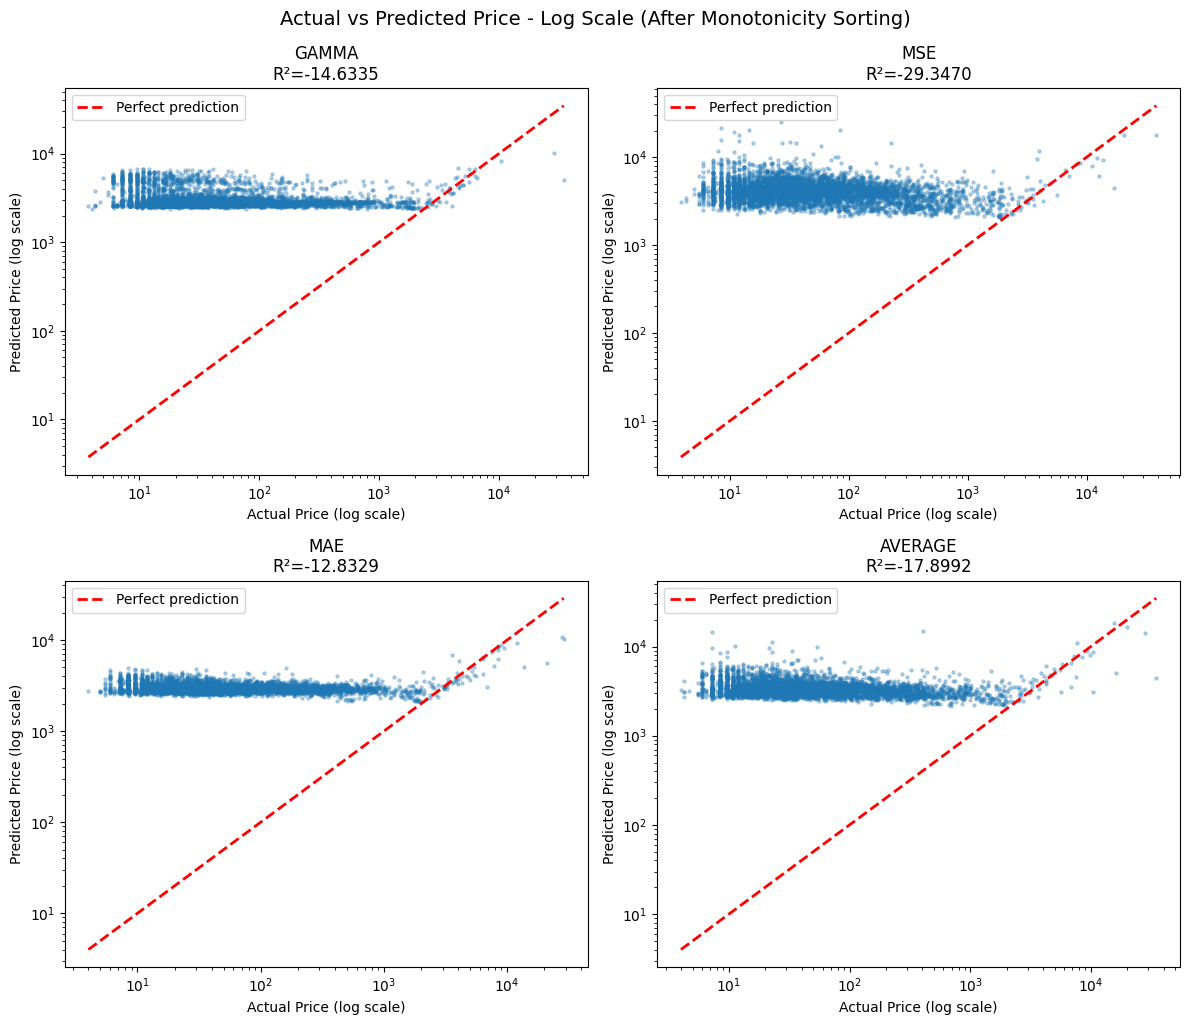

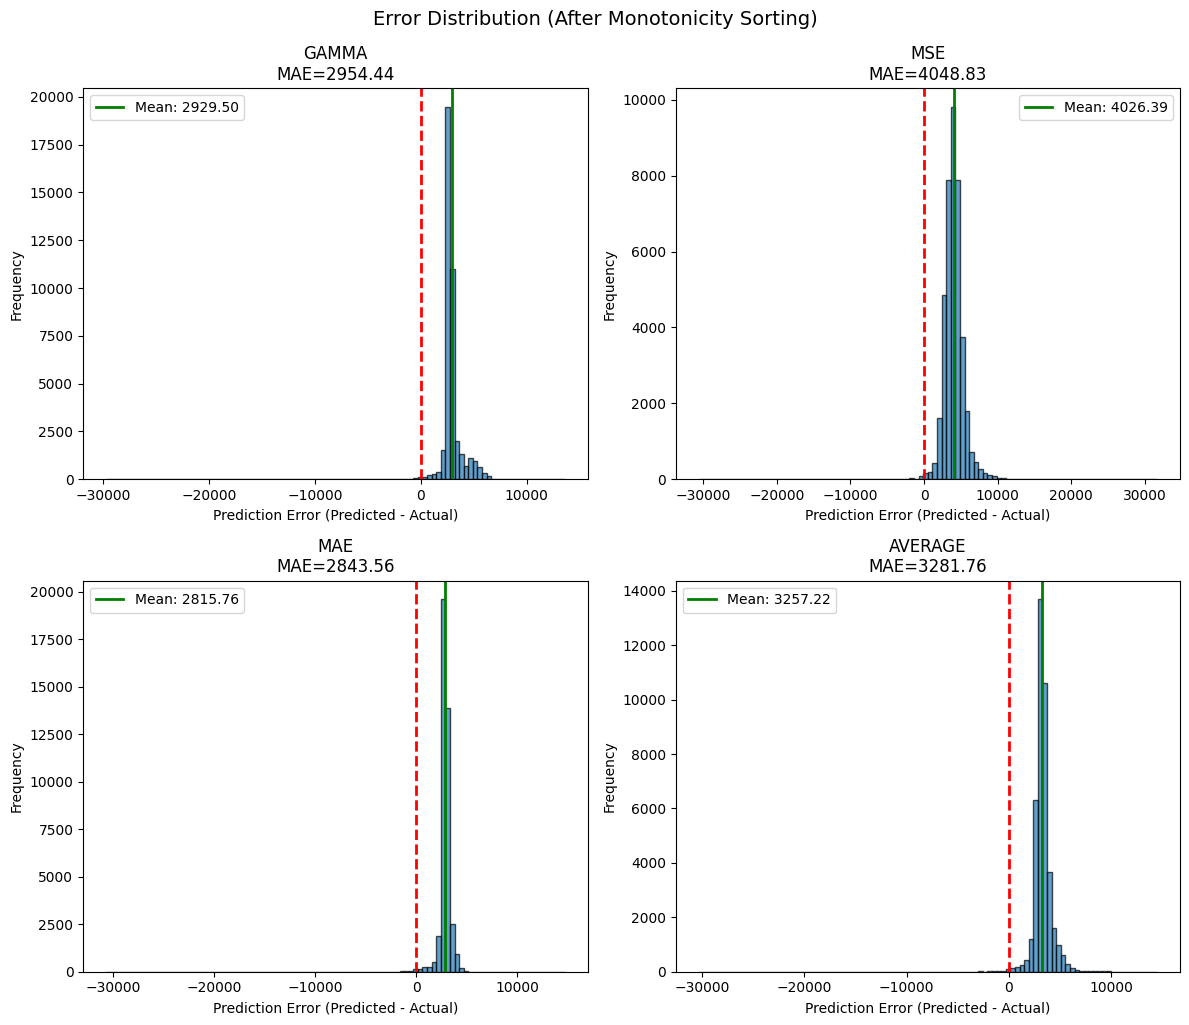

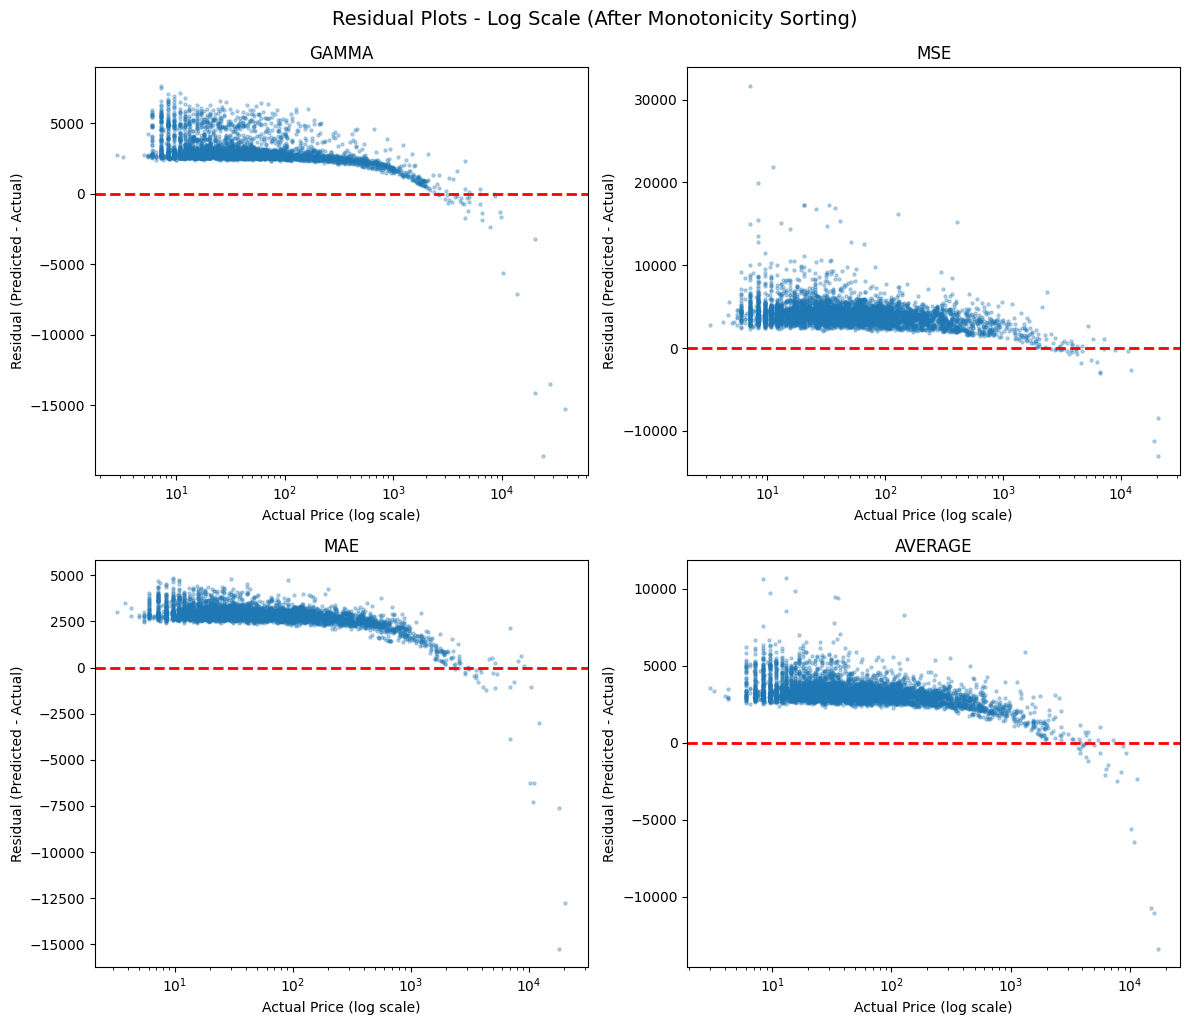

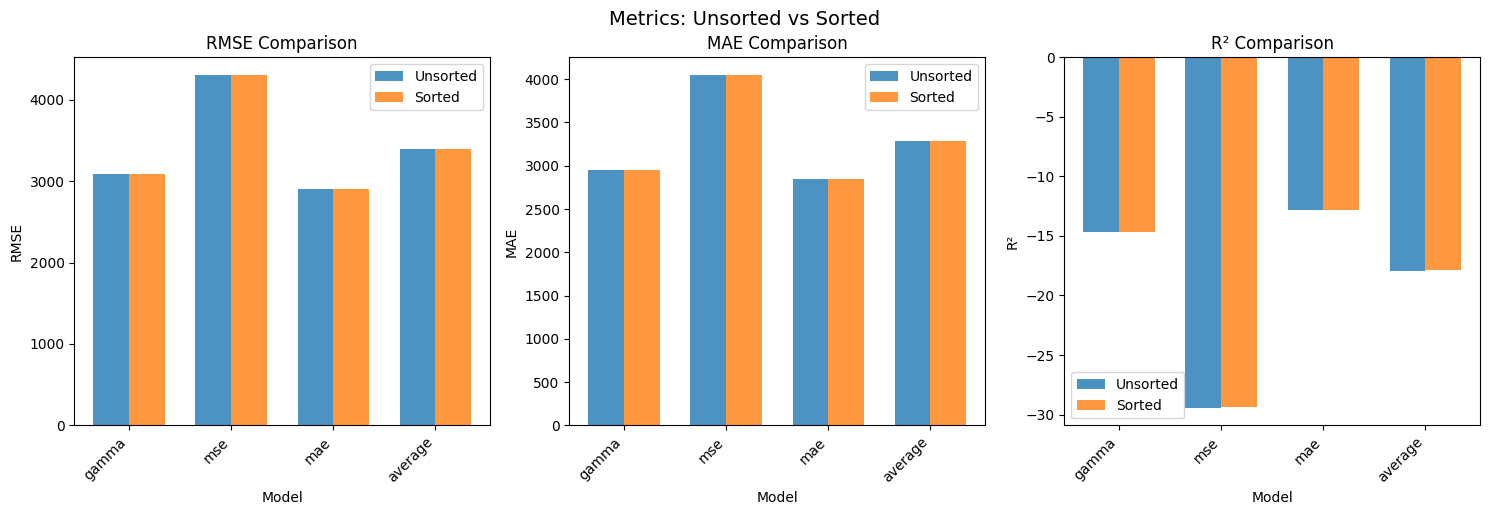


Visualizations saved to:
  - actual_vs_predicted.png
  - error_distribution.png
  - residual_plots.png
  - metrics_comparison.png


In [8]:
# Cell 8: Visualizations (Log-transformed axes)

# Use sorted_df for visualizations
viz_df = sorted_df.copy()

# Filter out non-positive values for log scale
viz_df = viz_df[viz_df["actual_price"] > 0].copy()
for col in prediction_cols:
    viz_df = viz_df[viz_df[col] > 0]

print(f"Visualization data: {len(viz_df)} samples (after filtering for log scale)")

# 1. Actual vs Predicted scatter plots (log-log scale)
n_models = len(prediction_cols)
fig, axes = plt.subplots(2, (n_models + 1) // 2, figsize=(6 * ((n_models + 1) // 2), 10))
axes = axes.flatten()

for idx, col in enumerate(prediction_cols):
    ax = axes[idx]
    y_true = viz_df["actual_price"].values
    y_pred = viz_df[col].values
    
    # Sample for visualization if too many points
    if len(y_true) > 5000:
        sample_idx = np.random.choice(len(y_true), 5000, replace=False)
        y_true_sample = y_true[sample_idx]
        y_pred_sample = y_pred[sample_idx]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    ax.scatter(y_true_sample, y_pred_sample, alpha=0.3, s=5)
    
    # Add perfect prediction line
    min_val = max(min(y_true_sample.min(), y_pred_sample.min()), 1)
    max_val = max(y_true_sample.max(), y_pred_sample.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
    
    ax.set_xlabel('Actual Price (log scale)')
    ax.set_ylabel('Predicted Price (log scale)')
    ax.set_title(f'{col.replace("prediction_", "").upper()}\nR²={metrics_sorted[col]["R²"]:.4f}')
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')

# Hide extra subplots if odd number of models
for idx in range(len(prediction_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Actual vs Predicted Price - Log Scale (After Monotonicity Sorting)', y=1.02, fontsize=14)
plt.savefig('actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()


# 2. Error distribution histograms
fig, axes = plt.subplots(2, (n_models + 1) // 2, figsize=(6 * ((n_models + 1) // 2), 10))
axes = axes.flatten()

for idx, col in enumerate(prediction_cols):
    ax = axes[idx]
    errors = viz_df[col].values - viz_df["actual_price"].values
    
    ax.hist(errors, bins=100, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='r', linestyle='--', lw=2)
    ax.axvline(x=errors.mean(), color='g', linestyle='-', lw=2, label=f'Mean: {errors.mean():.2f}')
    
    ax.set_xlabel('Prediction Error (Predicted - Actual)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{col.replace("prediction_", "").upper()}\nMAE={metrics_sorted[col]["MAE"]:.2f}')
    ax.legend()

# Hide extra subplots
for idx in range(len(prediction_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Error Distribution (After Monotonicity Sorting)', y=1.02, fontsize=14)
plt.savefig('error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


# 3. Residual plots (error vs actual price) - log scale on x-axis
fig, axes = plt.subplots(2, (n_models + 1) // 2, figsize=(6 * ((n_models + 1) // 2), 10))
axes = axes.flatten()

for idx, col in enumerate(prediction_cols):
    ax = axes[idx]
    y_true = viz_df["actual_price"].values
    errors = viz_df[col].values - y_true
    
    # Sample for visualization if too many points
    if len(y_true) > 5000:
        sample_idx = np.random.choice(len(y_true), 5000, replace=False)
        y_true_sample = y_true[sample_idx]
        errors_sample = errors[sample_idx]
    else:
        y_true_sample = y_true
        errors_sample = errors
    
    ax.scatter(y_true_sample, errors_sample, alpha=0.3, s=5)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax.set_xlabel('Actual Price (log scale)')
    ax.set_ylabel('Residual (Predicted - Actual)')
    ax.set_title(f'{col.replace("prediction_", "").upper()}')
    ax.set_xscale('log')

# Hide extra subplots
for idx in range(len(prediction_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Residual Plots - Log Scale (After Monotonicity Sorting)', y=1.02, fontsize=14)
plt.savefig('residual_plots.png', dpi=150, bbox_inches='tight')
plt.show()


# 4. Metrics comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['RMSE', 'MAE', 'R²']
model_names = [col.replace('prediction_', '') for col in prediction_cols]

for ax, metric in zip(axes, metrics_to_plot):
    unsorted_vals = [metrics_unsorted[col][metric] for col in prediction_cols]
    sorted_vals = [metrics_sorted[col][metric] for col in prediction_cols]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, unsorted_vals, width, label='Unsorted', alpha=0.8)
    bars2 = ax.bar(x + width/2, sorted_vals, width, label='Sorted', alpha=0.8)
    
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend()

plt.tight_layout()
plt.suptitle('Metrics: Unsorted vs Sorted', y=1.02, fontsize=14)
plt.savefig('metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualizations saved to:")
print("  - actual_vs_predicted.png")
print("  - error_distribution.png")
print("  - residual_plots.png")
print("  - metrics_comparison.png")

Price range: $1.60 to $38400.00
Base-2 logarithmic bin edges: [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]

Samples per price bin:
price_bin
$0-$1                 0
$1-$2                 1
$2-$4                20
$4-$8              1190
$8-$16             7155
$16-$32            8829
$32-$64            7982
$64-$128           6228
$128-$256          4083
$256-$512          2635
$512-$1,024        1292
$1,024-$2,048       663
$2,048-$4,096       244
$4,096-$8,192       119
$8,192-$16,384       49
$16,384-$32,768      15
$32,768-$65,536       3
Name: count, dtype: int64

BEST MODEL BY PRICE RANGE (Median Absolute Percentage Error)
    Price Range  Sample Count  MdAPE_gamma  MdAPE_mse  MdAPE_mae  MdAPE_average Best Model
          $1-$2             1    171711.52  247918.34  188479.41      202703.10      GAMMA
          $2-$4            20     85469.54  122330.95   81939.39       97870.97        MAE
          $4-$8          1190     47674.02   61

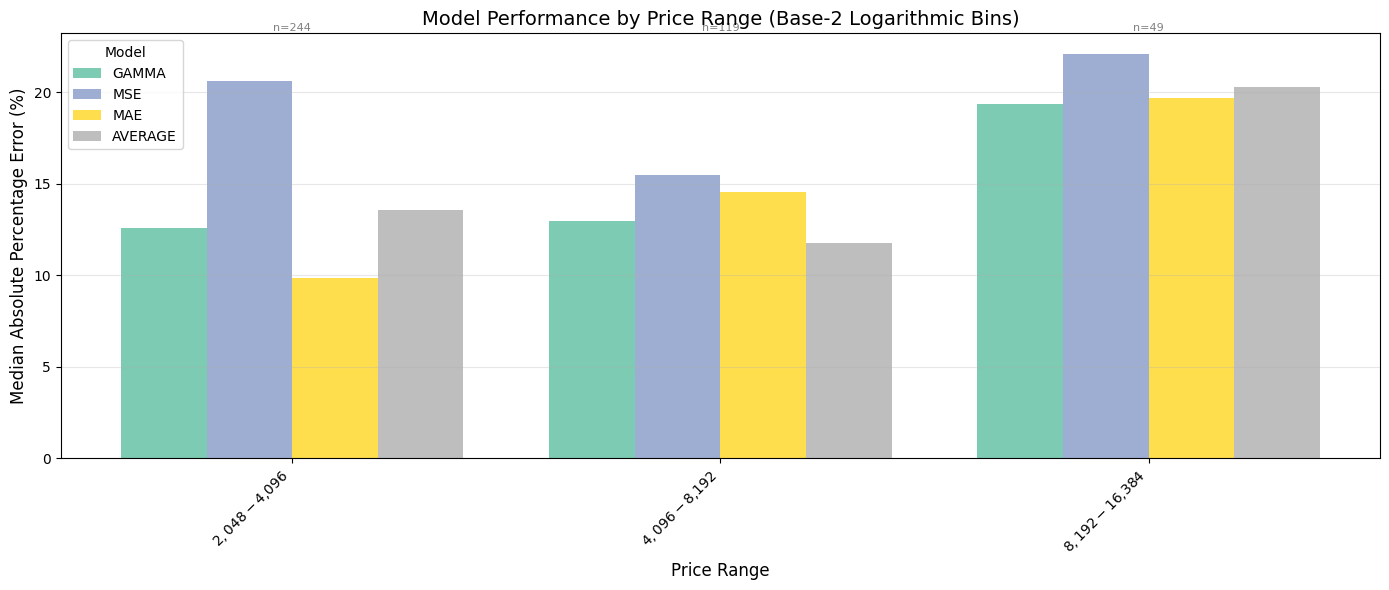


RECOMMENDATIONS

Optimal model selection by card price:
                 $1-$2: Use GAMMA (MdAPE: 171711.52%)
                 $2-$4: Use MAE (MdAPE: 81939.39%)
                 $4-$8: Use MAE (MdAPE: 45006.64%)
                $8-$16: Use MAE (MdAPE: 25599.47%)
               $16-$32: Use MAE (MdAPE: 13043.39%)
               $32-$64: Use GAMMA (MdAPE: 6397.37%)
              $64-$128: Use GAMMA (MdAPE: 3173.73%)
             $128-$256: Use GAMMA (MdAPE: 1530.24%)
             $256-$512: Use GAMMA (MdAPE: 712.59%)
           $512-$1,024: Use MAE (MdAPE: 306.29%)
         $1,024-$2,048: Use MAE (MdAPE: 74.57%)
         $2,048-$4,096: Use MAE (MdAPE: 9.84%)
         $4,096-$8,192: Use GAMMA (MdAPE: 13.00%)
        $8,192-$16,384: Use GAMMA (MdAPE: 19.34%)
       $16,384-$32,768: Use MSE (MdAPE: 57.99%)
       $32,768-$65,536: Use GAMMA (MdAPE: 52.90%)

Visualization saved to: model_by_price_range.png


In [12]:
# Cell 9: Best Model by Price Range Analysis (Base-2 Logarithmic Bins)

# Configuration: Bins to exclude from visualization (data still included in tables)
# Example: ["$1-$2", "$2-$4"] to exclude low-value bins with few samples
EXCLUDE_BINS_FROM_VIZ = ["$1-$2", "$2-$4", "$4-$8", "$8-$16", "$16-$32", "$32-$64", "$64-$128", "$128-$256", "$256-$512", "$512-$1,024", "$1,024-$2,048", "$16,384-$32,768", "$32,768-$65,536"]


def median_absolute_percentage_error(y_true, y_pred):
    """Calculate Median Absolute Percentage Error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# Use sorted_df for analysis
analysis_df = sorted_df.copy()

# Create base-2 logarithmic price bins
# Bins: $0-2, $2-4, $4-8, $8-16, $16-32, $32-64, $64-128, $128-256, $256-512, $512-1024, $1024+
min_price = analysis_df["actual_price"].min()
max_price = analysis_df["actual_price"].max()

# Generate bin edges as powers of 2
min_exp = max(0, int(np.floor(np.log2(max(min_price, 1)))))  # Start at 2^0 = 1 minimum
max_exp = int(np.ceil(np.log2(max_price))) + 1

bin_edges = [0] + [2**i for i in range(min_exp, max_exp)]
bin_edges = sorted(set(bin_edges))  # Remove duplicates and sort

# Create labels for the bins
bin_labels = []
for i in range(len(bin_edges) - 1):
    if bin_edges[i+1] >= 1024:
        bin_labels.append(f"${bin_edges[i]:,.0f}-${bin_edges[i+1]:,.0f}")
    else:
        bin_labels.append(f"${bin_edges[i]:.0f}-${bin_edges[i+1]:.0f}")

# Assign each row to a price bin
analysis_df["price_bin"] = pd.cut(
    analysis_df["actual_price"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True,
    right=True
)

print(f"Price range: ${min_price:.2f} to ${max_price:.2f}")
print(f"Base-2 logarithmic bin edges: {bin_edges}")
print(f"\nSamples per price bin:")
print(analysis_df["price_bin"].value_counts().sort_index())

# Calculate MdAPE for each model in each price bin
model_cols = [c for c in prediction_cols if c != "prediction_average"]
all_model_cols = prediction_cols  # Include average for comparison

results_by_bin = []

for bin_label in bin_labels:
    bin_data = analysis_df[analysis_df["price_bin"] == bin_label]
    if len(bin_data) == 0:
        continue
    
    row = {
        "Price Range": bin_label,
        "Sample Count": len(bin_data),
    }
    
    y_true = bin_data["actual_price"].values
    
    mdape_values = {}
    for col in all_model_cols:
        y_pred = bin_data[col].values
        mdape = median_absolute_percentage_error(y_true, y_pred)
        model_name = col.replace("prediction_", "")
        row[f"MdAPE_{model_name}"] = mdape
        mdape_values[model_name] = mdape
    
    # Determine best model (excluding average)
    model_only_mdape = {k: v for k, v in mdape_values.items() if k != "average"}
    best_model = min(model_only_mdape, key=model_only_mdape.get)
    row["Best Model"] = best_model.upper()
    row["Best MdAPE"] = model_only_mdape[best_model]
    
    results_by_bin.append(row)

# Create summary DataFrame
summary_df = pd.DataFrame(results_by_bin)

print("\n" + "=" * 80)
print("BEST MODEL BY PRICE RANGE (Median Absolute Percentage Error)")
print("=" * 80)

# Display formatted table
display_cols = ["Price Range", "Sample Count"] + [f"MdAPE_{c.replace('prediction_', '')}" for c in all_model_cols] + ["Best Model"]
print(summary_df[display_cols].to_string(index=False, float_format=lambda x: f"{x:.2f}" if isinstance(x, float) else x))

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY: Model Performance by Price Segment")
print("=" * 80)

best_model_counts = summary_df["Best Model"].value_counts()
print("\nNumber of price ranges where each model is best:")
for model, count in best_model_counts.items():
    print(f"  {model}: {count} price range(s)")

# Weighted analysis (by sample count)
print("\nWeighted performance (by sample count in each range):")
for col in all_model_cols:
    model_name = col.replace("prediction_", "")
    weighted_mdape = np.average(
        summary_df[f"MdAPE_{model_name}"],
        weights=summary_df["Sample Count"]
    )
    print(f"  {model_name.upper()}: {weighted_mdape:.2f}% weighted MdAPE")


# Visualization: MdAPE by Price Range for each model
# Filter out excluded bins for visualization only
viz_summary_df = summary_df[~summary_df["Price Range"].isin(EXCLUDE_BINS_FROM_VIZ)].reset_index(drop=True)

if len(EXCLUDE_BINS_FROM_VIZ) > 0:
    print(f"\nExcluding {len(EXCLUDE_BINS_FROM_VIZ)} bin(s) from visualization: {EXCLUDE_BINS_FROM_VIZ}")

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(viz_summary_df))
width = 0.2
colors = plt.cm.Set2(np.linspace(0, 1, len(all_model_cols)))

for i, col in enumerate(all_model_cols):
    model_name = col.replace("prediction_", "")
    mdape_col = f"MdAPE_{model_name}"
    offset = (i - len(all_model_cols) / 2 + 0.5) * width
    bars = ax.bar(x + offset, viz_summary_df[mdape_col], width, 
                  label=model_name.upper(), color=colors[i], alpha=0.85)

ax.set_xlabel("Price Range", fontsize=12)
ax.set_ylabel("Median Absolute Percentage Error (%)", fontsize=12)
ax.set_title("Model Performance by Price Range (Base-2 Logarithmic Bins)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(viz_summary_df["Price Range"], rotation=45, ha="right")
ax.legend(title="Model")
ax.grid(axis="y", alpha=0.3)

# Add sample count annotations at the top
for i, (_, row) in enumerate(viz_summary_df.iterrows()):
    ax.annotate(f'n={row["Sample Count"]:,}', xy=(i, ax.get_ylim()[1]), 
                ha='center', va='bottom', fontsize=8, color='gray')

plt.tight_layout()
plt.savefig('model_by_price_range.png', dpi=150, bbox_inches='tight')
plt.show()


# Highlight the recommended model for each segment
print("\n" + "=" * 80)
print("RECOMMENDATIONS")
print("=" * 80)
print("\nOptimal model selection by card price:")
for _, row in summary_df.iterrows():
    print(f"  {row['Price Range']:>20}: Use {row['Best Model']} (MdAPE: {row['Best MdAPE']:.2f}%)")

print("\nVisualization saved to: model_by_price_range.png")
